https://mewo2.com/notes/terrain/

In [201]:
import math, random
import matplotlib, pandas

In [202]:
TERRAIN_NODES = 1024 * 16
WATER_RATIO = 0.3

In [226]:
def distance(a, b):
    return math.sqrt((a['X'] - b['X']) ** 2 + (a['Y'] - b['Y']) ** 2)

def push_pull(terr, n=4, r=256, s=1, direction=1, rng=(-100, 100)):
    
    rng_size = rng[1] - rng[0]
    rng_min = rng[0]
    
    flex_size = s * 0.1
    flex_min = 0 - 0.5 * flex_size
    
    for i in range(0, n):
        
        p = {
            'X': random.random() * rng_size + rng_min,
            'Y': random.random() * rng_size + rng_min,
        }
        
        radius = random.random() * r + (r/2)
        
        for t in terr:
            d = distance(p, t)
            if d <= radius:
                t['Z'] += ((1 - d/radius) * s + (random.random() * flex_size + flex_min)) * direction

## Create Initial Terrain Points

In [271]:
terr = []
terr_links = []

for y in range(0, 200):
    for x in range(0, 200):
        
        terr.append({
            'X_ID': x,
            'Y_ID': y,
            'X': random.random() * 0.5 - 100 + (x),
            'Y': random.random() * 0.5 - 100 + (y),
            'Z': 0
        })

## Establish Initial Coastline

* Push and pull terrain areas up and down.
* Normalize values and round out hills.
* Establish waterline base on height quantile.

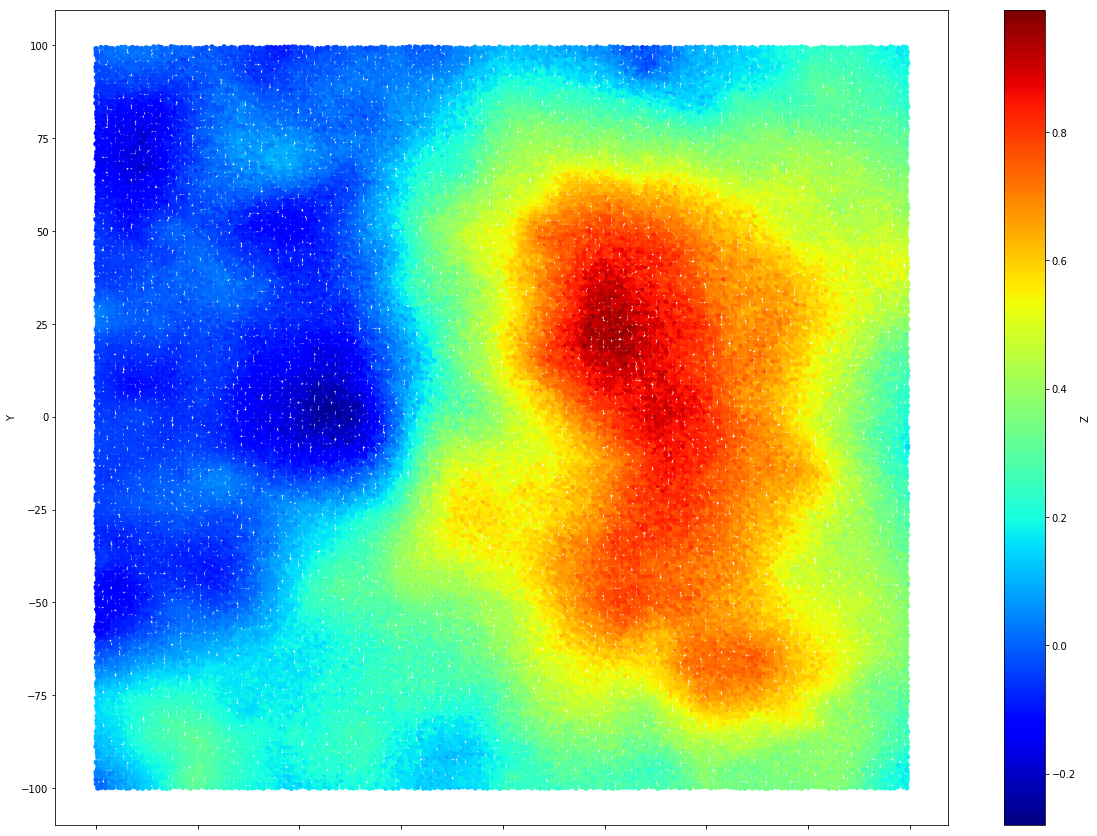

In [272]:
'''
terr = []

for i in range(0, TERRAIN_NODES):
    terr.append({
        'X': random.random() * 200 - 100,
        'Y': random.random() * 200 - 100,
        'Z': 0
    })
'''
    
# push_pull(terr)

# push_pull(terr, n=8, r=128, s=1/2.0, direction=-1)
push_pull(terr, n=16, r=64, s=1/4.0)
push_pull(terr, n=32, r=32, s=1/8.0, direction=-1)
push_pull(terr, n=64, r=16, s=1/16.0)
push_pull(terr, n=128, r=8, s=1/32.0, direction=-1)
push_pull(terr, n=256, r=4, s=1/64.0)

terr_df = pandas.DataFrame(terr)
terr_df.plot(kind='scatter', x='X', y='Y',  c='Z', cmap=matplotlib.cm.get_cmap("jet"), figsize=(20,15))

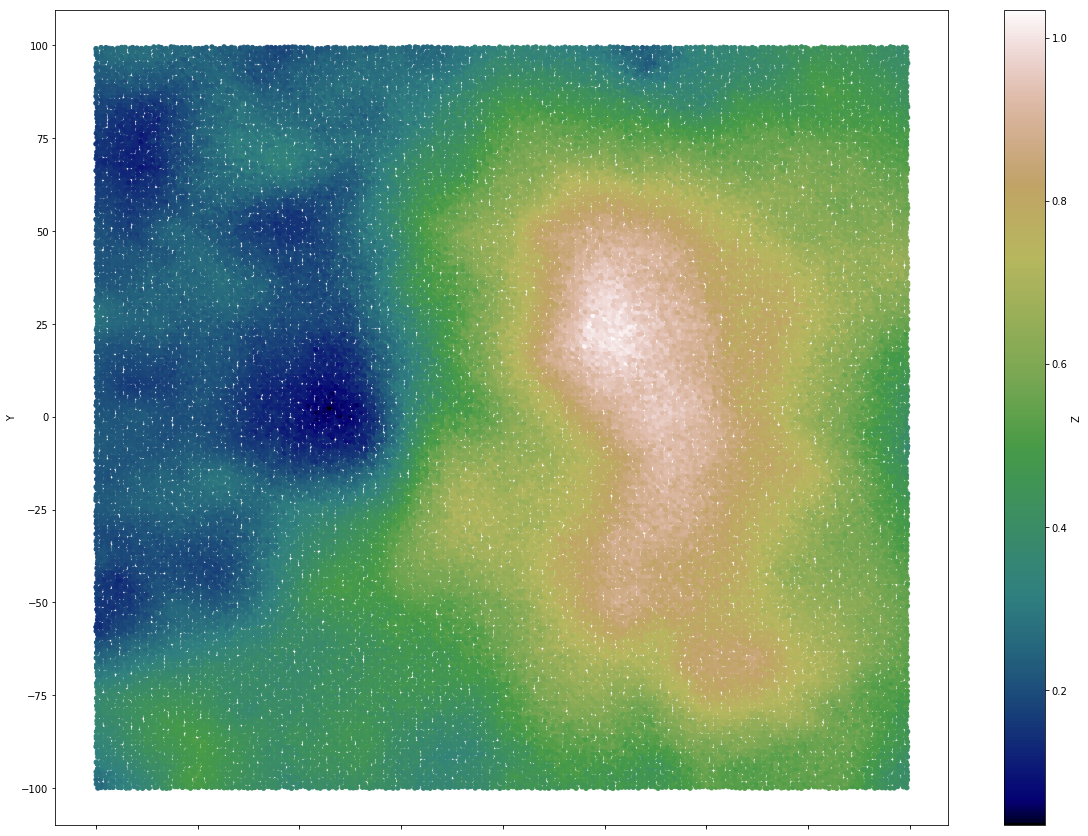

In [273]:
# normalize heightmap
terr_df['Z'] = (terr_df['Z'] - terr_df['Z'].mean()) / (terr_df['Z'].max() - terr_df['Z'].min()) + 0.5
terr_df.plot(kind='scatter', x='X', y='Y',  c='Z', cmap=matplotlib.cm.get_cmap("gist_earth"), figsize=(20,15))

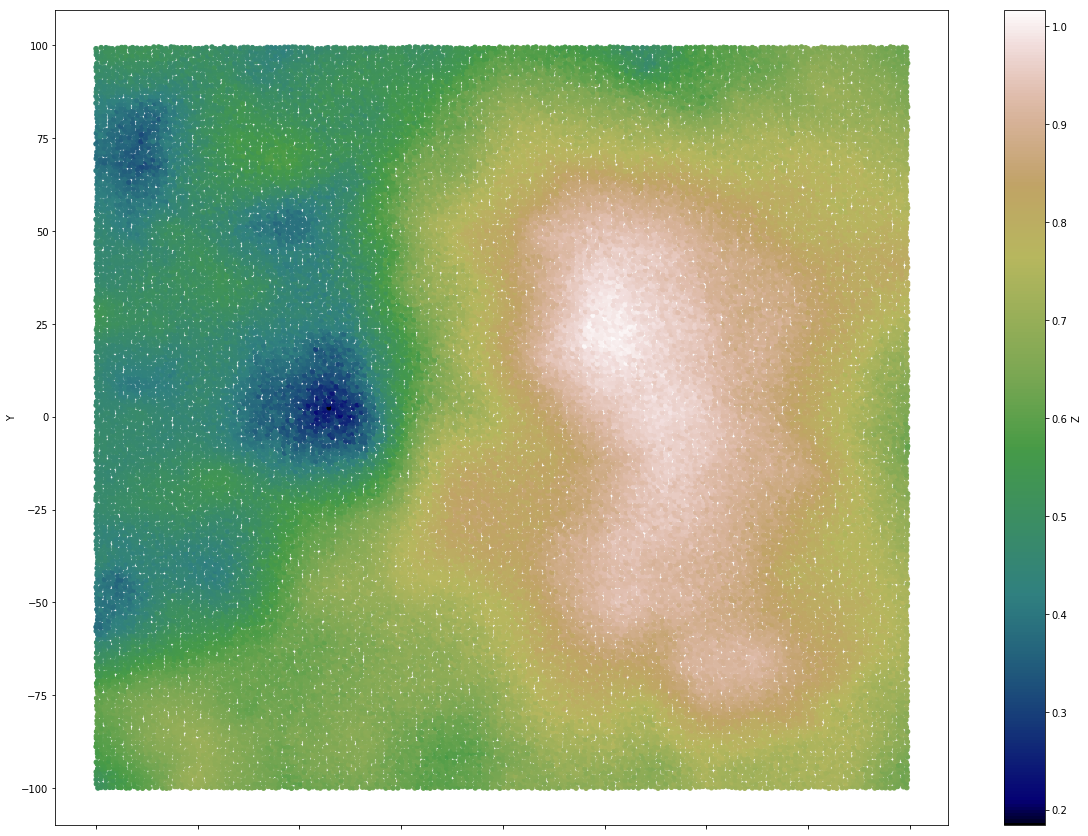

In [274]:
# round hills
terr_df['Z'] = terr_df['Z'].apply(lambda x: x ** 0.5)

'''
# smoothify
for x in range(0, 200):
    for y in range(0, 200):
        
        others = []
        
        if x > 0:
            others.append(terr_df[terr_df['X_ID'] == x - 1].iloc[0]['Z'])
        if x < 199:
            others.append(terr_df[terr_df['X_ID'] == x + 1].iloc[0]['Z'])
        if y > 0:
            others.append(terr_df[terr_df['Y_ID'] == y - 1].iloc[0]['Z'])
        if y < 199:
            others.append(terr_df[terr_df['Y_ID'] == y + 1].iloc[0]['Z'])
            
        index = terr_df[(terr_df['X_ID'] == x) & (terr_df['Y_ID'] == y)].index[0]
        # print(index)
        terr_df.at[index, 'Z'] = pandas.Series(others).mean()
        # print (terr_df.loc[index])
        # break
'''
            
terr_df.plot(kind='scatter', x='X', y='Y',  c='Z', cmap=matplotlib.cm.get_cmap("gist_earth"), figsize=(20,15))

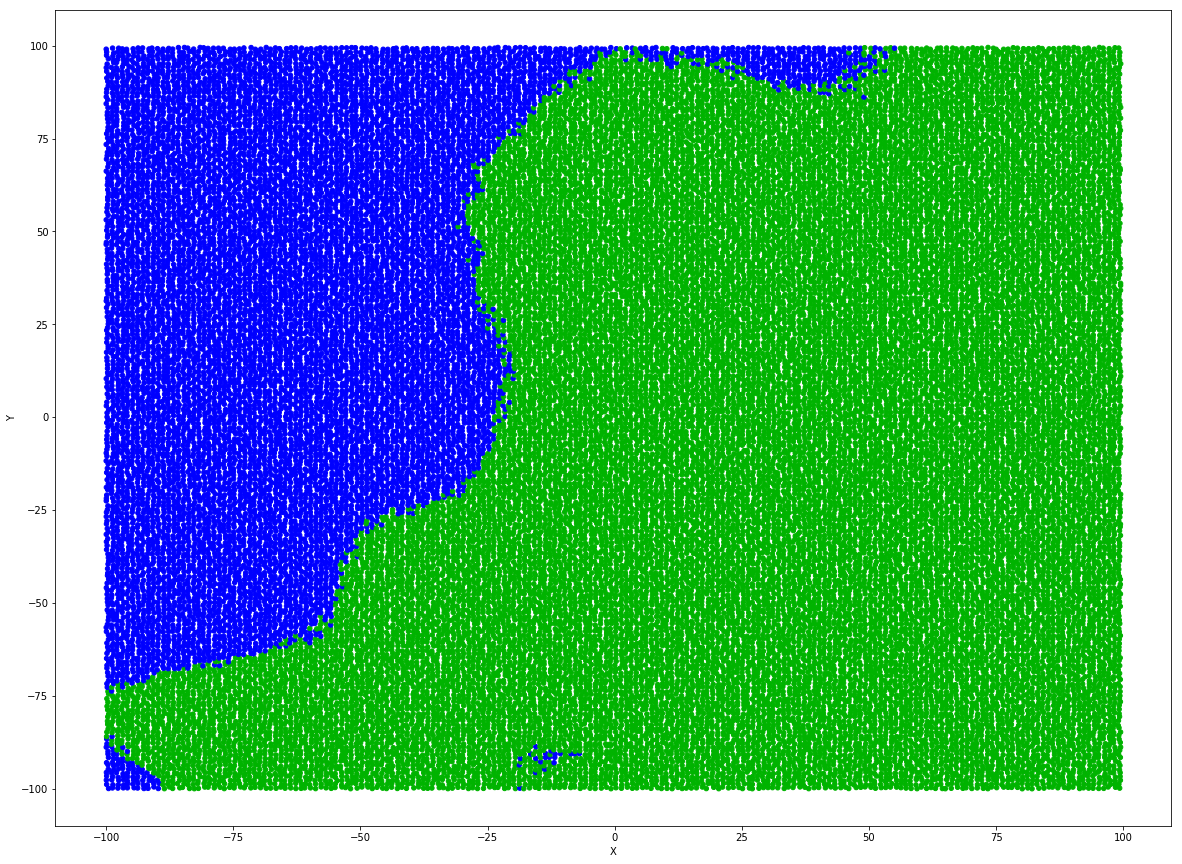

In [275]:
# show landmass
water_cutoff = terr_df['Z'].quantile(WATER_RATIO)

def cut_water(x):
    if x > water_cutoff:
        return (0, 0.7, 0)
    else:
        return (0, 0, 1)

terr_df['LandColor'] = terr_df['Z'].apply(cut_water)
terr_df.plot(kind='scatter', x='X', y='Y',  c=terr_df['LandColor'], figsize=(20,15))

## Simulate Erosion

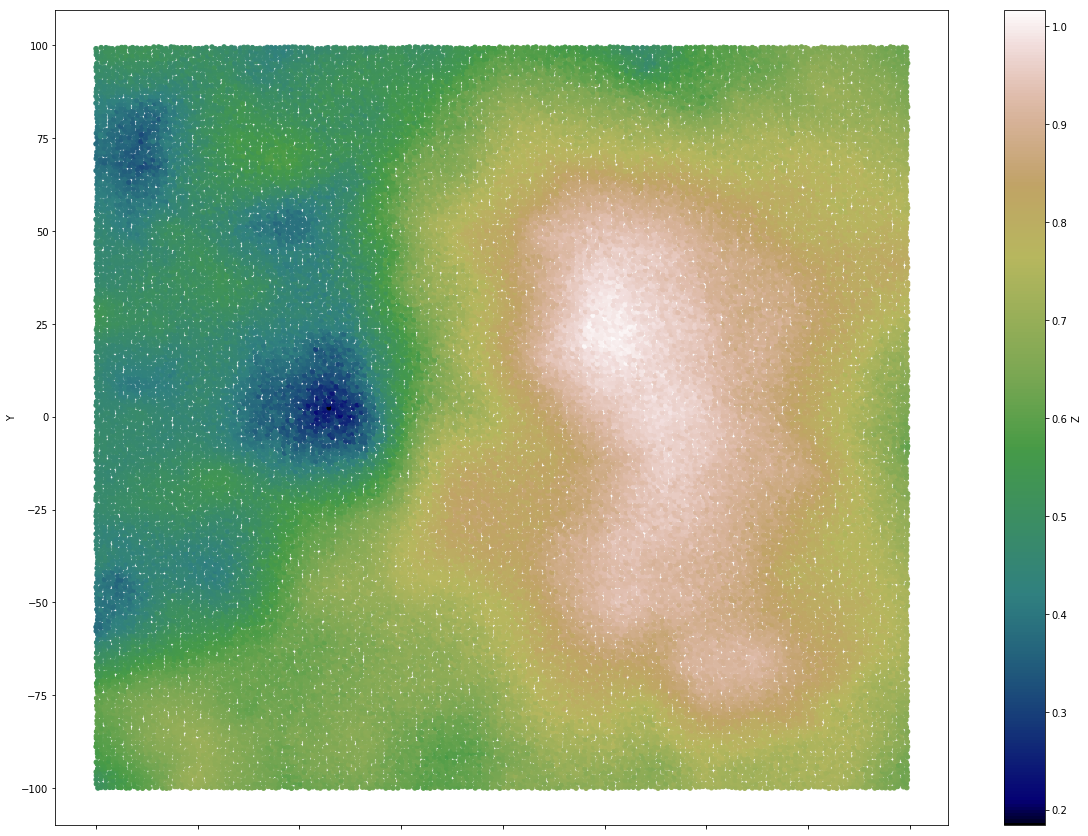

In [295]:
X_MIN, Y_MIN, X_MAX, Y_MAX = 0, 0, 199, 199

eroded_df = terr_df[['X_ID', 'Y_ID', 'X', 'Y', 'Z']].copy()

non_edges_filter = (eroded_df['X_ID'] > X_MIN) & (eroded_df['X_ID'] < X_MAX) & (eroded_df['Y_ID'] > Y_MIN) & (eroded_df['Y_ID'] < Y_MAX)
edges_filter = ~non_edges_filter

eroded_df.loc[non_edges_filter, 'Z'] = float('inf')

new_z_values = []

changed = True 

while changed:
    
    changed = False
    # need to figure out the loop
    
    for i, row in eroded_df.iterrows():

        neighbors_filter = (
            ((eroded_df['X_ID'] == row.X_ID + 1) & (eroded_df['Y_ID'] == row.Y_ID)) |
            ((eroded_df['X_ID'] == row.X_ID + 1) & (eroded_df['Y_ID'] == row.Y_ID)) |
            ((eroded_df['X_ID'] == row.X_ID) & (eroded_df['Y_ID'] == row.Y_ID + 1)) |
            ((eroded_df['X_ID'] == row.X_ID) & (eroded_df['Y_ID'] == row.Y_ID - 1))
        )
        neighbors_df = eroded_df[neighbors_filter]

        orig_z = terr_df[(terr_df['X_ID'] == row.X_ID) & (terr_df['Y_ID'] == row['Y_ID'])].iloc[0]['Z']
        min_neighbor_z = neighbors_df['Z'].min() + 0.01

        new_z_values.append(max((orig_z, min_neighbor_z)))

    
eroded_df['Z'] = new_z_values
eroded_df.plot(kind='scatter', x='X', y='Y',  c='Z', cmap=matplotlib.cm.get_cmap("gist_earth"), figsize=(20,15))

In [279]:
water_cutoff = terr_df['Z'].quantile(WATER_RATIO)

def cut_water(x):
    if x > water_cutoff:
        return (0, 0.7, 0)
    else:
        return (0, 0, 1)

199